In [1]:
import numpy as np
import pandas as pd
import seaborn as sms
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import scipy
import pymc.sampling_jax as jax
import aesara.tensor as at
import arviz as az
import pymc as pm
import scipy
import scipy.stats as st
import xarray as xr
from xarray_einstats.stats import XrContinuousRV
import pytensor.tensor as pt

# define true parameters
AA = 0.5
AA_er=0.1
Wide_M = 0.5
Probs=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
narrow_w=[.025,.025,.05,.1,.2,.4,.2,.1,.05,.025,.025]
narrow_w=np.divide(narrow_w,np.sum(narrow_w))
wide_w=[.5,.2,.1,.05,.05,.01,.05,.05,.1,.2,.5]
wide_w=np.divide(wide_w,np.sum(wide_w))
prize=7
trials=50
pers=np.arange(0.03, 0.99, 0.02).tolist()

N = 50
sd = 0.3  # represents change between pre and post test with zero measurement error

# No measurement error, but random change from pre to post


/home/strange/anaconda3/lib/python3.7/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## AMBIGUITY Model With W2P measure

1. Simulate Model and Experiment with W2P measure


,subs,sig,dist,V_A,belief_0,belief_1,belief_2,belief_3,belief_4,belief_5,belief_6,belief_7,belief_8,belief_9,belief_10
0,0,0.832,narrow,3.219801,1,1,1,0,4,8,2,1,2,0,0
1,0,0.832,wide,3.538753,3,3,1,1,1,0,2,0,2,2,5
2,1,0.520,narrow,3.512277,0,0,0,4,3,7,1,4,0,0,1
3,1,0.520,wide,2.675947,5,2,2,0,0,0,1,0,0,2,8
4,2,3.720,narrow,3.574458,0,0,1,0,4,10,5,0,0,0,0


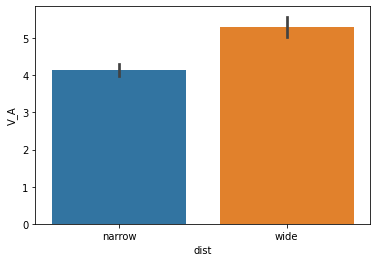

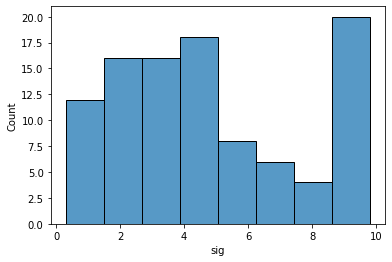

In [2]:
data=[]
for sub in range(N):
    #AA_s=np.around(scipy.stats.halfnorm.rvs(.2),3)
    AA_s=np.around(scipy.stats.uniform.rvs(0.05,10),3)
    #AA_s=AA_s[0]
    #AA_s=.2
    #for trial in pers:
    NB=np.random.choice(a=Probs,p=narrow_w,size=20,replace=True)
    WB=np.random.choice(a=Probs,p=wide_w,size=20,replace=True)
    #for trial in pers:
    for dist in ['narrow','wide']:
        #print(dist)
        if dist=='narrow':
            V_A=(np.mean((NB*7)**AA_s))**(1/AA_s)
            B=NB
            data.append([sub,AA_s,dist,V_A,
                 np.sum(B==0),np.sum(B==.1),np.sum(B==.2),
                 np.sum(B==.3),np.sum(B==.4),np.sum(B==.5),
                 np.sum(B==.6),np.sum(B==.7),np.sum(B==.8),
                 np.sum(B==.9),np.sum(B==1)])

        if dist=='wide':
            V_A=(np.mean((WB*7)**AA_s))**(1/AA_s)
            B=WB
            data.append([sub,AA_s,dist,V_A,
                 np.sum(B==0),np.sum(B==.1),np.sum(B==.2),
                 np.sum(B==.3),np.sum(B==.4),np.sum(B==.5),
                 np.sum(B==.6),np.sum(B==.7),np.sum(B==.8),
                 np.sum(B==.9),np.sum(B==1)])

            
df=pd.DataFrame(columns=['subs','sig','dist','V_A','belief_0','belief_1','belief_2',
                        'belief_3','belief_4','belief_5','belief_6','belief_7','belief_8',
                        'belief_9','belief_10',],data=data)
display(df.head())
sms.barplot(x='dist',y='V_A',data=df)
plt.show()
sms.histplot(x='sig',data=df)
plt.show()

In [3]:

subs_idxs, subs = pd.factorize(df.subs)

coords = {
    "Subs": subs,
    "obs_id": np.arange(len(subs_idxs)),
}

In [4]:

with pm.Model(coords=coords) as risk_model:
    #priors
    sub_idx = pm.Data("sub_idx", subs_idxs, dims="obs_id")
    
    mu_AA=pm.HalfNormal("MUalpha",1)
    sd_AA=pm.HalfNormal("sd_AA",4)
    
    error=pm.HalfNormal("error",3)
    
    AA=pm.Weibull("sig", mu_AA,sd_AA,dims="Subs")
    
    p_0= pm.MutableData("belief_0", df["belief_0"].values, dims="obs_id")
    p_1= pm.MutableData("belief_1", df["belief_1"].values, dims="obs_id")
    p_2= pm.MutableData("belief_2", df["belief_2"].values, dims="obs_id")
    p_3= pm.MutableData("belief_3", df["belief_3"].values, dims="obs_id")
    p_4= pm.MutableData("belief_4", df["belief_4"].values, dims="obs_id")
    p_5= pm.MutableData("belief_5", df["belief_5"].values, dims="obs_id")
    p_6= pm.MutableData("belief_6", df["belief_6"].values, dims="obs_id")
    p_7= pm.MutableData("belief_7", df["belief_7"].values, dims="obs_id")
    p_8= pm.MutableData("belief_8", df["belief_8"].values, dims="obs_id")
    p_9= pm.MutableData("belief_9", df["belief_9"].values, dims="obs_id")
    p_10= pm.MutableData("belief_10", df["belief_10"].values, dims="obs_id")
    
    
    val_0=((0*7)**AA[sub_idx])*p_0
    val_1=((0.1*7)**AA[sub_idx])*p_1
    val_2=((0.2*7)**AA[sub_idx])*p_2
    val_3=((0.3*7)**AA[sub_idx])*p_3
    val_4=((0.4*7)**AA[sub_idx])*p_4
    val_5=((0.5*7)**AA[sub_idx])*p_5
    val_6=((0.6*7)**AA[sub_idx])*p_6
    val_7=((0.7*7)**AA[sub_idx])*p_7
    val_8=((0.8*7)**AA[sub_idx])*p_8
    val_9=((0.9*7)**AA[sub_idx])*p_9
    val_10=((1.0*7)**AA[sub_idx])*p_10
    
    V_A=pm.Deterministic('V_A', (np.sum([val_0,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10])/20)**(1/AA[sub_idx]))
                  
    y=pm.Normal("Value",mu=V_A,sigma=error,observed=df['V_A'])

/home/strange/anaconda3/lib/python3.7/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  UserWarning,


## Model Visualization

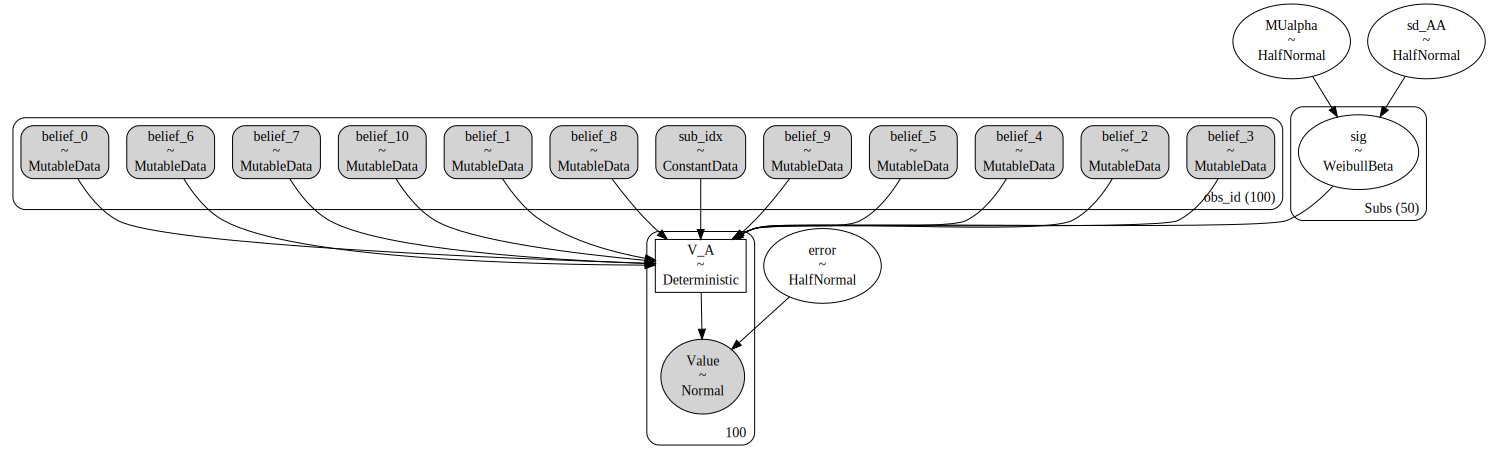

In [5]:
pm.model_to_graphviz(risk_model)

# Model Fitting
1. 4 chains with 500 samples This is small because the data is simulated

In [6]:
with risk_model:
    # draw 1000 posterior samples
    #idata = pm.sample(500)
    idata=jax.sample_numpyro_nuts(2000, tune=1000, target_accept=0.9)

Compiling...
Compilation time =  0:00:05.903496
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:15.433277
Transforming variables...
Transformation time =  0:00:00.975358
Computing Log Likelihood...
Log Likelihood time =  0:00:00.900202


## Plot posteriors and convergence of chains

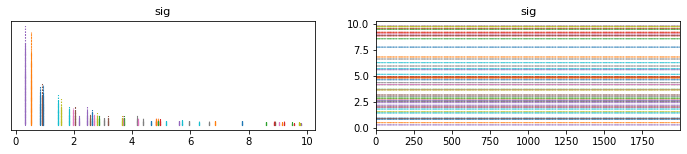

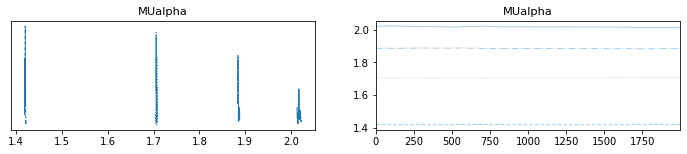

In [7]:
az.plot_trace(idata.posterior['sig'])
plt.show()
az.plot_trace(idata.posterior['MUalpha'])
plt.show()

The correlation between ground truth simulation and and extracted parameters is r: 0.9999999999999998 p: 0.0


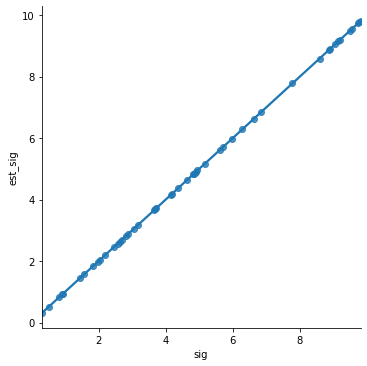

In [8]:
from scipy.stats import pearsonr
plt_df=df.groupby(by='subs').mean()
plt_df['est_sig']=idata.posterior['sig'].mean(dim=["chain", "draw"]).values
r,p=pearsonr(plt_df['est_sig'],plt_df['sig'])
print("The correlation between ground truth simulation and and extracted parameters is r: %s p: %s"%(r,p))
sms.lmplot(x='sig',y='est_sig',data=plt_df)
plt.show()

## Ambiguity Model with 2AFC measure

In [9]:
# define true parameters
AA = 0.5
AA_er=0.1
Wide_M = 0.5
Probs=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
narrow_w=[.025,.025,.05,.1,.2,.4,.2,.1,.05,.025,.025]
narrow_w=np.divide(narrow_w,np.sum(narrow_w))
wide_w=[.5,.2,.1,.05,.05,.01,.05,.05,.1,.2,.5]
wide_w=np.divide(wide_w,np.sum(wide_w))
prize=7
trials=50
pers=np.arange(0, 1, 0.03).tolist()

N = 20
sd = 0.3  # represents change between pre and post test with zero measurement error


In [43]:
from scipy.special import softmax
from scipy.stats import lognorm
data=[]
for sub in range(N):
    #AA_s=np.around(scipy.stats.halfnorm.rvs(loc=.5, scale=1),3)
    AA_s=np.around(scipy.stats.uniform.rvs(0.1,3),3)
    #AA_s=.2
    NB=np.random.choice(a=Probs,p=narrow_w,size=20,replace=True)
    WB=np.random.choice(a=Probs,p=wide_w,size=20,replace=True)
    for dist in ['narrow','wide']:
        for trial in pers:
            V_R= (trial*7)**AA_s
            if dist=='narrow':
                V_A=(np.mean((NB*7)**AA_s))
                B=NB  
                Q = np.array([V_R, V_A])
                prob_a = softmax(Q)
                prob_a=prob_a[0]
                #prob_a =np.exp(V_R)/(np.exp(V_R)+np.exp(V_A))
                choice = np.random.choice([1, 0], p=[prob_a,1-prob_a])
                
                data.append([sub,AA_s,dist,trial,choice,prob_a,Q,V_R,V_A,
                        np.sum(B==0),np.sum(B==.1),np.sum(B==.2),
                        np.sum(B==.3),np.sum(B==.4),np.sum(B==.5),
                        np.sum(B==.6),np.sum(B==.7),np.sum(B==.8),
                        np.sum(B==.9),np.sum(B==1)])

            if dist=='wide':
                V_A=(np.mean((WB*7)**AA_s))
                B=WB
                Q = np.array([V_R, V_A])
                prob_a = softmax(Q)
                prob_a=prob_a[0]
                #prob_a =np.exp(V_R)/(np.exp(V_R)+np.exp(V_A))
                
                choice = np.random.choice([1, 0], p=[prob_a,1-prob_a])
                
                data.append([sub,AA_s,dist,trial,choice,prob_a,Q,V_R,V_A,
                        np.sum(B==0),np.sum(B==.1),np.sum(B==.2),
                        np.sum(B==.3),np.sum(B==.4),np.sum(B==.5),
                        np.sum(B==.6),np.sum(B==.7),np.sum(B==.8),
                        np.sum(B==.9),np.sum(B==1)])
            

In [44]:
df=pd.DataFrame(columns=['subs','sig','dist','per','choice','probs','Q','V_R','V_A','belief_0','belief_1','belief_2',
                        'belief_3','belief_4','belief_5','belief_6','belief_7','belief_8',
                        'belief_9','belief_10',],data=data)
df['Choose_Risk']=df['choice']==1
df.head()

,subs,sig,dist,per,choice,probs,Q,V_R,V_A,belief_0,...,belief_2,belief_3,belief_4,belief_5,belief_6,belief_7,belief_8,belief_9,belief_10,Choose_Risk
0,0,1.705,narrow,0.00,0,0.000149,"[0.0, 8.811522590552135]",0.000000,8.811523,0,...,1,0,6,8,2,2,1,0,0,False
1,0,1.705,narrow,0.03,0,0.000160,"[0.06988498841684228, 8.811522590552135]",0.069885,8.811523,0,...,1,0,6,8,2,2,1,0,0,False
2,0,1.705,narrow,0.06,0,0.000187,"[0.22784528203538437, 8.811522590552135]",0.227845,8.811523,0,...,1,0,6,8,2,2,1,0,0,False
3,0,1.705,narrow,0.09,0,0.000235,"[0.4548577898741694, 8.811522590552135]",0.454858,8.811523,0,...,1,0,6,8,2,2,1,0,0,False
4,0,1.705,narrow,0.12,0,0.000313,"[0.742841541822059, 8.811522590552135]",0.742842,8.811523,0,...,1,0,6,8,2,2,1,0,0,False


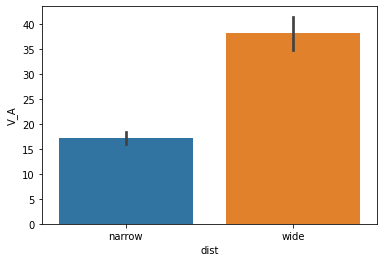

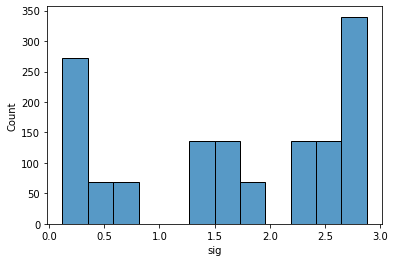

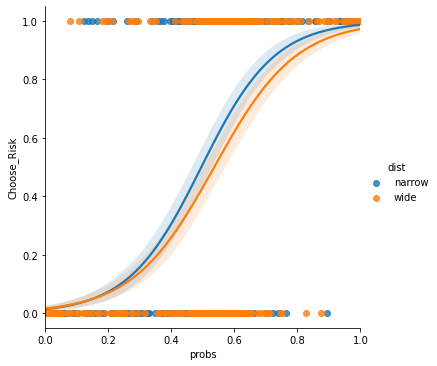

In [45]:
sms.barplot(x='dist',y='V_A',data=df)
plt.show()
sms.histplot(x='sig',data=df)
plt.show()
sms.lmplot(x='probs',y='Choose_Risk',logistic=True,data=df,hue='dist')

# Define Model

In [46]:
subs_idxs, subs = pd.factorize(df.subs)

coords = {
    "Subs": subs,
    "obs_id": np.arange(len(subs_idxs)),
}

In [50]:
risk_model=[]
with pm.Model(coords=coords) as risk_model:
    #priors
    sub_idx = pm.Data("sub_idx", subs_idxs, dims="obs_id")
    
    #mu_AA=pm.HalfNormal("MUalpha",1)
    #sd_AA=pm.HalfNormal("sd_AA",4)
    
    error=pm.HalfNormal("error",3)
    
    #AA=pm.Weibull("sig", mu_AA,sd_AA,dims="Subs")
    AA=pm.Uniform("sig",0.01,3,dims="Subs")
    
    p_0= pm.MutableData("belief_0", df["belief_0"].values, dims="obs_id")
    p_1= pm.MutableData("belief_1", df["belief_1"].values, dims="obs_id")
    p_2= pm.MutableData("belief_2", df["belief_2"].values, dims="obs_id")
    p_3= pm.MutableData("belief_3", df["belief_3"].values, dims="obs_id")
    p_4= pm.MutableData("belief_4", df["belief_4"].values, dims="obs_id")
    p_5= pm.MutableData("belief_5", df["belief_5"].values, dims="obs_id")
    p_6= pm.MutableData("belief_6", df["belief_6"].values, dims="obs_id")
    p_7= pm.MutableData("belief_7", df["belief_7"].values, dims="obs_id")
    p_8= pm.MutableData("belief_8", df["belief_8"].values, dims="obs_id")
    p_9= pm.MutableData("belief_9", df["belief_9"].values, dims="obs_id")
    p_10= pm.MutableData("belief_10", df["belief_10"].values, dims="obs_id")
    
    
    val_0=((0*7)**AA[sub_idx])*p_0
    val_1=((0.1*7)**AA[sub_idx])*p_1
    val_2=((0.2*7)**AA[sub_idx])*p_2
    val_3=((0.3*7)**AA[sub_idx])*p_3
    val_4=((0.4*7)**AA[sub_idx])*p_4
    val_5=((0.5*7)**AA[sub_idx])*p_5
    val_6=((0.6*7)**AA[sub_idx])*p_6
    val_7=((0.7*7)**AA[sub_idx])*p_7
    val_8=((0.8*7)**AA[sub_idx])*p_8
    val_9=((0.9*7)**AA[sub_idx])*p_9
    val_10=((1.0*7)**AA[sub_idx])*p_10
    
    V_A=pm.Deterministic('V_A', (np.sum([val_0,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,val_10])/20))
    #y=pm.Normal("Value",mu=V_A,sigma=error,observed=df['V_A'])
    
    risks=pm.MutableData('risks',df['per'].values,dims="obs_id")
    V_R=pm.Deterministic('V_R',(risks*7)**AA[sub_idx])
    #z=pm.Normal("W2P_R",mu=V_R,sigma=error,observed=df['V_R'])
    
    #prob_a=pm.math.exp(V_R*beta[sub_idx])/(pm.math.exp(V_R*beta[sub_idx])+pm.math.exp(V_A*beta[sub_idx]))
    prob_a=np.exp(V_R)/(np.exp(V_R)+np.exp(V_A))
    
    #a=pm.Normal("probs",mu=prob_a,sigma=error,observed=df['probs'])
    y = pm.Bernoulli("Choose_risk", p=prob_a, observed=df['Choose_Risk'])


/home/strange/anaconda3/lib/python3.7/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  UserWarning,


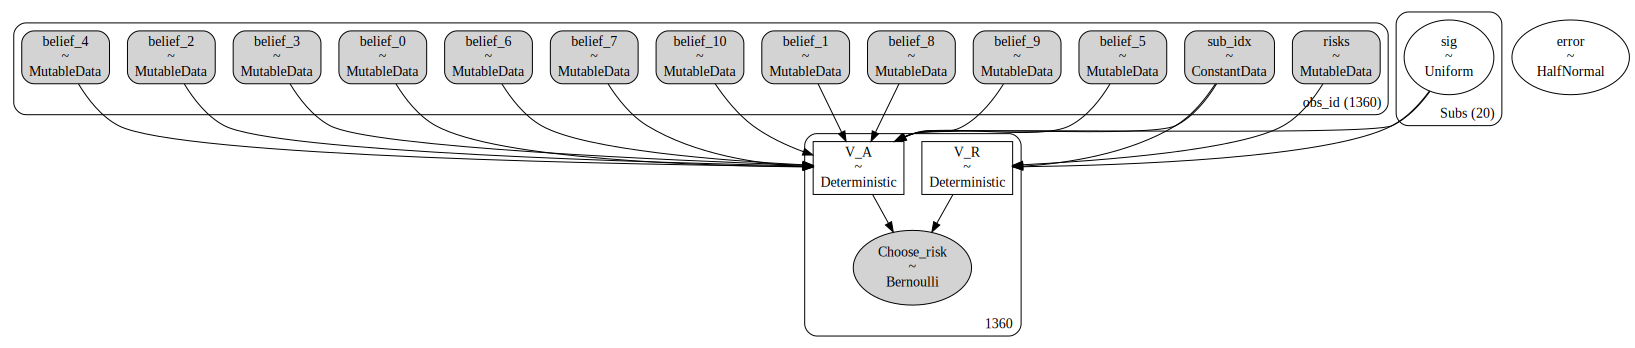

In [51]:
fig=pm.model_to_graphviz(risk_model)
fig.render('KMM-graphviz.pdf',view=False)
pm.model_to_graphviz(risk_model)

In [52]:
#import pymc.sampling.jax as pmjax
idata=[]
with risk_model:
    # draw 1000 posterior samples
    idata = pm.sample(500,cores=4)
    #idata=jax.sample_numpyro_nuts(800, tune=800, target_accept=0.88)


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, sig]
INFO:pymc:NUTS: [error, sig]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 45 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 45 seconds.


## Plot posteriors and convergence of chains

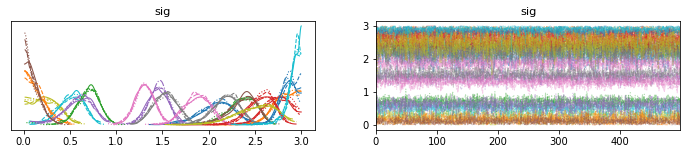

In [53]:
az.plot_trace(idata.posterior['sig'])
plt.show()

,sig,per,choice,probs,V_R,V_A,belief_0,belief_1,belief_2,belief_3,belief_4,belief_5,belief_6,belief_7,belief_8,belief_9,belief_10,Choose_Risk,est_sig
subs,,,,,,,,,,,,,,,,,,,
0,1.705,0.495,0.397059,0.425368,10.136977,10.763658,2.5,1.5,1.0,0.0,3.0,4.0,2.5,1.0,0.5,0.5,3.5,0.397059,2.088569
1,2.643,0.495,0.367647,0.382991,46.910548,52.264299,3.0,1.0,1.0,2.0,1.0,4.0,2.5,0.5,1.0,0.5,3.5,0.367647,2.814236
2,2.232,0.495,0.397059,0.400886,23.717656,24.295197,2.0,3.0,0.5,1.5,1.5,3.0,2.5,1.0,1.5,1.5,2.0,0.397059,2.355066
3,2.877,0.495,0.367647,0.361743,69.577536,83.341408,2.5,2.5,1.5,1.0,2.0,2.5,2.0,0.5,0.5,1.0,4.0,0.367647,2.735750
4,1.274,0.495,0.529412,0.519459,5.201488,4.707444,5.0,2.0,1.0,1.0,1.0,1.5,3.0,0.5,1.0,1.0,3.0,0.529412,1.455306
5,2.602,0.495,0.367647,0.357466,43.797798,51.090720,1.0,3.0,2.0,0.5,2.0,3.5,0.5,2.0,1.5,0.5,3.5,0.367647,2.365382
6,1.757,0.495,0.426471,0.429034,11.007617,11.370764,4.0,0.5,1.0,1.5,1.0,5.0,0.5,2.0,0.0,1.5,3.0,0.426471,1.874045
7,1.514,0.495,0.441176,0.436193,7.514380,7.999099,3.0,0.5,1.0,1.0,1.5,3.0,4.5,0.5,1.5,1.5,2.0,0.441176,1.531651
8,0.123,0.495,0.455882,0.513805,1.105593,1.052729,2.0,1.0,1.5,1.0,3.0,3.0,3.0,0.0,0.0,2.0,3.5,0.455882,0.238258


The correlation between ground truth simulation and and extracted parameters is r**2: 0.9686512007971957 p: 5.501476573904108e-15


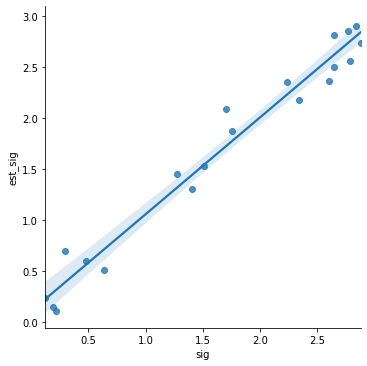

In [54]:
from scipy.stats import pearsonr
plt_df=df.groupby(by='subs').mean()
plt_df['est_sig']=idata.posterior['sig'].mean(dim=["chain", "draw"])

display(plt_df.head(10))
r,p=pearsonr(plt_df['est_sig'],plt_df['sig'])
print("The correlation between ground truth simulation and and extracted parameters is r**2: %s p: %s"%(r**2,p))
sms.lmplot(x='sig',y='est_sig',data=plt_df)
plt.show()

In [ ]:
idata